In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
binary_data_dir = 'E:\\aal90_short_binaries'
file_prefix = 'data_ts_'
file_suffix = '.bin'
subject_id = '28742'
file_path = os.path.join(binary_data_dir, f'{file_prefix}{subject_id}{file_suffix}')
print(file_path)

E:\aal90_short_binaries\data_ts_28742.bin


In [3]:
num_cols = 152

In [4]:
data_np = np.fromfile(file_path, np.float64).reshape( (-1, num_cols), order='C' )
print( data_np.shape )

(116, 152)


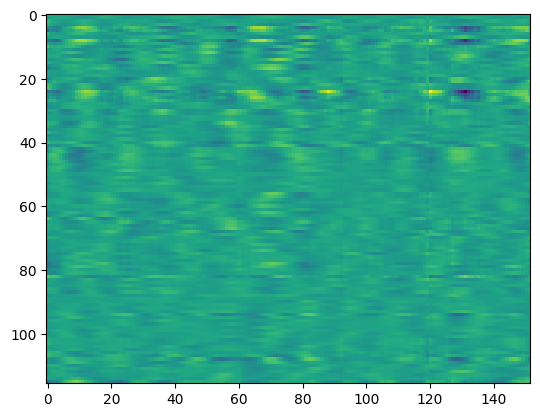

In [5]:
plt.imshow(data_np)

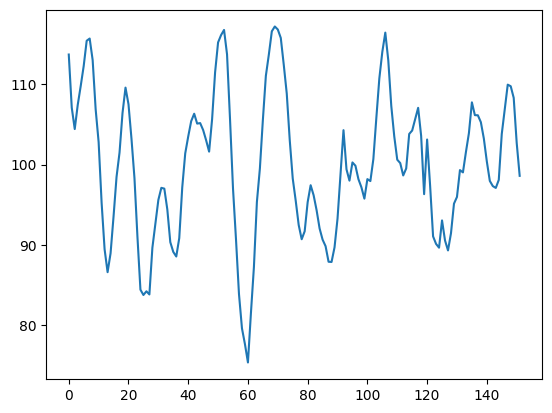

In [6]:
plt.plot( data_np[0,:] )

In [7]:
device = torch.device('cuda')
dtype = torch.float
data_torch = torch.from_numpy(data_np).to(device, dtype=dtype)
print( data_torch.size() )

torch.Size([116, 152])


In [8]:
data_padded = torch.nn.functional.pad(data_torch, pad=[0, 300, 0, 0], value=0)
print( data_padded.size() )

torch.Size([116, 452])


In [9]:
files = os.listdir(path=binary_data_dir)
print( len(files) )

446


In [10]:
num_rows = 116
data_list = [np.fromfile( os.path.join(binary_data_dir, file), np.float64 ).reshape( (num_rows, -1), order='C' ) for file in files]
print( len(data_list) )

446


In [11]:
max_length = max([ data.shape[-1] for data in data_list ])
print(max_length)

300


In [12]:
device = torch.device('cuda')
dtype = torch.float
data_torch_list = [torch.from_numpy(data).to(device, dtype=dtype).transpose(dim0=0, dim1=1) for data in data_list]

In [13]:
data_ts = torch.nn.utils.rnn.pad_sequence(data_torch_list, batch_first=True, padding_value=0.0, padding_side='right').transpose(dim0=-2, dim1=-1)
print( data_ts.size() )

torch.Size([446, 116, 300])


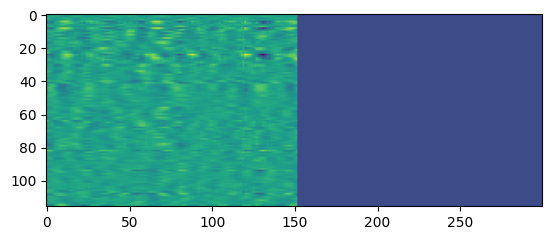

In [14]:
plt.imshow( data_ts[0,:,:].detach().cpu().numpy() )

In [15]:
data_means = torch.stack( [ts.mean(dim=0) for ts in data_torch_list], dim=0 )
print( data_means.size() )

torch.Size([446, 116])


In [16]:
data_mean_products = torch.stack(  [torch.matmul( ts.transpose(dim0=0,dim1=1), ts )/ts.size(dim=0) for ts in data_torch_list], dim=0  )
print( data_mean_products.size() )

torch.Size([446, 116, 116])


In [17]:
data_cov = data_mean_products - data_means.unsqueeze(dim=-2) * data_means.unsqueeze(dim=-1)
print( data_cov.size() )

torch.Size([446, 116, 116])


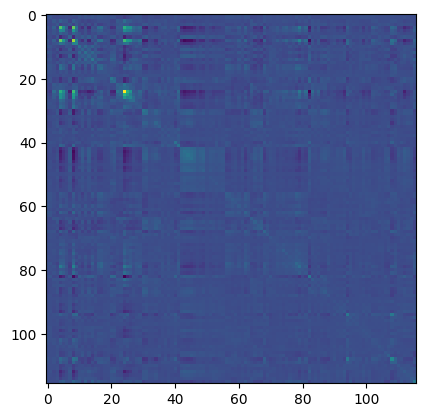

In [18]:
plt.imshow( data_cov[0,:,:].detach().cpu().numpy() )

In [19]:
data_std = torch.stack( [ts.std(dim=0) for ts in data_torch_list], dim=0 )
print( data_std.size() )

torch.Size([446, 116])


In [20]:
data_fc = data_mean_products /( data_std.unsqueeze(dim=-2) * data_std.unsqueeze(dim=-1) )
print( data_fc.size() )

torch.Size([446, 116, 116])


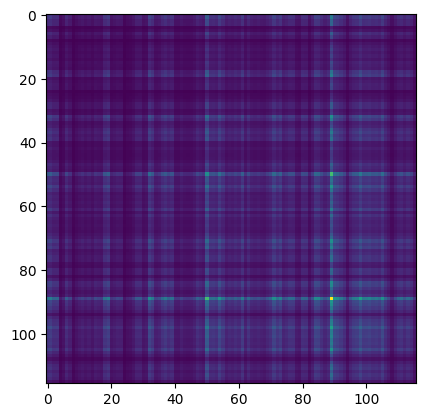

In [21]:
plt.imshow( data_fc[0,:,:].detach().cpu().numpy() )

In [22]:
test = torch.tensor([1.0, 2.0, 4.0])
print( test )
test_copy = torch.zeros_like(test)
print( test_copy )
test_copy.copy_(test)
print(test_copy)
test_copy[1] = 3.0
print(test_copy)
print(test)

tensor([1., 2., 4.])
tensor([0., 0., 0.])
tensor([1., 2., 4.])
tensor([1., 3., 4.])
tensor([1., 2., 4.])


In [6]:
output_dir = 'E:\\aal90_short_pytorch'

In [7]:
fc_corr_file = os.path.join(output_dir, 'fc_corr_test_length_120000_ising_model_aal_short_threshold_1_beta_updates_9.pt_beta_min_1e-09_max_0.09')
fc_corr = torch.load(fc_corr_file, weights_only=False)
print( fc_corr.size() )

torch.Size([101, 446])


In [8]:
num_nan = torch.count_nonzero( torch.isnan(fc_corr) )
num_corr = fc_corr.numel()
print(f'{num_nan} of {num_corr} ({num_nan/num_corr:.3g}) correlations are NaN.')

3957 of 45046 (0.0878) correlations are NaN.


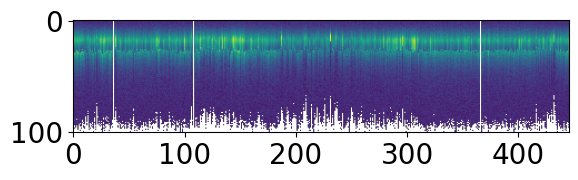

In [10]:
# plt.imshow( depytorch(fc_corr[:13,:223]) )
plt.imshow( depytorch(fc_corr) )

In [16]:
has_any_corrs = torch.any(  torch.logical_not( torch.isnan(fc_corr) ), dim=-1  )
betas = torch.linspace( start=1e-09, end=1.0, steps=fc_corr.size(dim=0), dtype=fc_corr.dtype, device=fc_corr.device )
print( 'betas for which we have non-NaN corrs:', betas[has_any_corrs].tolist() )

betas for which we have non-NaN corrs: [9.999999717180685e-10, 0.010000000707805157, 0.020000001415610313, 0.030000001192092896, 0.03999999910593033, 0.05000000074505806, 0.05999999865889549, 0.07000000029802322, 0.07999999821186066, 0.08999999612569809, 0.10000000149011612, 0.10999999940395355, 0.11999999731779099, 0.12999999523162842, 0.14000000059604645, 0.14999999105930328, 0.1599999964237213, 0.17000000178813934, 0.17999999225139618, 0.1899999976158142, 0.20000000298023224, 0.20999999344348907, 0.2199999988079071, 0.22999998927116394, 0.23999999463558197, 0.25, 0.25999999046325684, 0.26999998092651367, 0.2800000011920929, 0.28999999165534973, 0.29999998211860657, 0.3100000023841858, 0.3199999928474426, 0.32999998331069946, 0.3400000035762787, 0.3499999940395355, 0.35999998450279236, 0.3700000047683716, 0.3799999952316284, 0.38999998569488525, 0.4000000059604645, 0.4099999964237213, 0.41999998688697815, 0.429999977350235, 0.4399999976158142, 0.44999998807907104, 0.4599999785423279,

In [22]:
has_any_corrs_subj = torch.any(  torch.logical_not( torch.isnan(fc_corr) ), dim=0  )
num_has_any_subj = torch.count_nonzero(has_any_corrs_subj)
num_subj = has_any_corrs_subj.numel()
print( f'{num_has_any_subj} of {num_subj} ({num_has_any_subj/num_subj:.3g}) subjects have non-NaN corrs.' )

443 of 446 (0.993) subjects have non-NaN corrs.


In [23]:
fc_corr_non_nan_subj = fc_corr[:,has_any_corrs_subj]
fc_corr_min = fc_corr_non_nan_subj.min(dim=-1).values
fc_corr_median = fc_corr_non_nan_subj.median(dim=-1).values
fc_corr_max = fc_corr_non_nan_subj.max(dim=-1).values

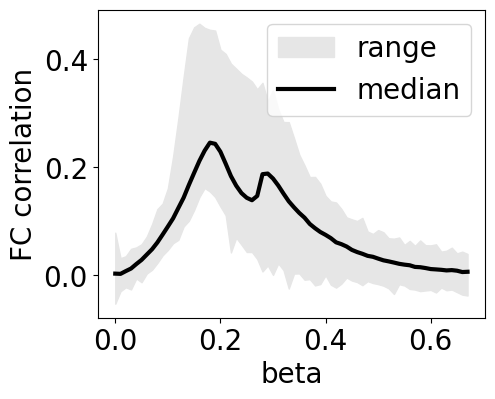

In [24]:
plot_index_start = 0
plot_index_end = 101
betas_np = depytorch(betas[plot_index_start:plot_index_end])
fc_corr_min_np = depytorch(fc_corr_min[plot_index_start:plot_index_end])
fc_corr_median_np = depytorch(fc_corr_median[plot_index_start:plot_index_end])
fc_corr_max_np = depytorch(fc_corr_max[plot_index_start:plot_index_end])

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3.0
cval = [0.0, 0.0, 0.0]
axs.fill_between( betas_np, fc_corr_min_np, fc_corr_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
axs.plot( betas_np, fc_corr_median_np, color=cval, linewidth=line_width, label=f'median' )
axs.legend()
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()

In [26]:
median_not_nan = torch.logical_not( torch.isnan(fc_corr_median) )
fc_corr_median_not_nan = fc_corr_median[median_not_nan]
best_index_for_fc_corr = torch.argmax(fc_corr_median_not_nan)
best_beta_for_fc_corr = (betas[median_not_nan])[best_index_for_fc_corr]
best_fc_corr_min = (fc_corr_min[median_not_nan])[best_index_for_fc_corr]
best_fc_corr_median = fc_corr_median_not_nan[best_index_for_fc_corr]
best_fc_corr_max = (fc_corr_max[median_not_nan])[best_index_for_fc_corr]
print(f'best median FC corr. occurs at beta {best_beta_for_fc_corr:.3g}, FC corr. min {best_fc_corr_min:.3g} median {best_fc_corr_median:.3g} max {best_fc_corr_max:.3g}')

best median FC corr. occurs at beta 0.18, FC corr. min 0.155 median 0.246 max 0.455


In [11]:
cov_rmse_file = os.path.join(output_dir, 'cov_rmse_test_length_120000_ising_model_aal_short_threshold_1_beta_updates_9.pt_beta_min_1e-09_max_0.09')
cov_rmse = torch.load(cov_rmse_file, weights_only=False)
print( cov_rmse.size() )

torch.Size([101, 446])


In [12]:
num_nan = torch.count_nonzero( torch.isnan(cov_rmse) )
num_rmse = cov_rmse.numel()
print(f'{num_nan} of {num_rmse} ({num_nan/num_rmse:.3g}) covariance RMSEs are NaN.')

0 of 45046 (0) covariance RMSEs are NaN.


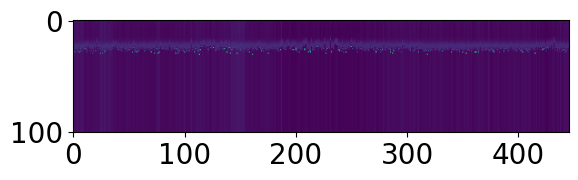

In [13]:
plt.imshow( depytorch(cov_rmse) )

In [14]:
cov_rmse_min = cov_rmse.min(dim=-1).values
cov_rmse_median = cov_rmse.median(dim=-1).values
cov_rmse_max = cov_rmse.max(dim=-1).values

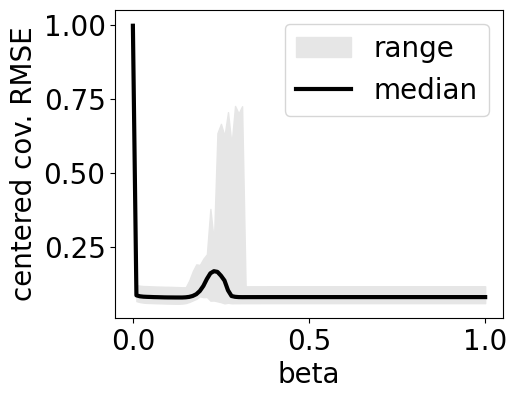

In [18]:
plot_index_start = 0
plot_index_end = 101
betas_np = depytorch(betas[plot_index_start:plot_index_end])
cov_rmse_min_np = depytorch(cov_rmse_min[plot_index_start:plot_index_end])
cov_rmse_median_np = depytorch(cov_rmse_median[plot_index_start:plot_index_end])
cov_rmse_max_np = depytorch(cov_rmse_max[plot_index_start:plot_index_end])

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3.0
cval = [0.0, 0.0, 0.0]
axs.fill_between( betas_np, cov_rmse_min_np, cov_rmse_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
axs.plot( betas_np, cov_rmse_median_np, color=cval, linewidth=line_width, label=f'median' )
axs.legend()
axs.set_xlabel('beta')
axs.set_ylabel('centered cov. RMSE')
plt.show()

In [19]:
print( betas[0].item(), betas[1].item(), betas[2].item(), betas[3].item() )
print( cov_rmse_median[0].item(), cov_rmse_median[1].item(), cov_rmse_median[2].item(), cov_rmse_median[3].item() )

9.999999717180685e-10 0.010000000707805157 0.020000001415610313 0.030000001192092896
0.9966875910758972 0.087430939078331 0.08430999517440796 0.08297799527645111
